In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lena = np.load("lena.npy")

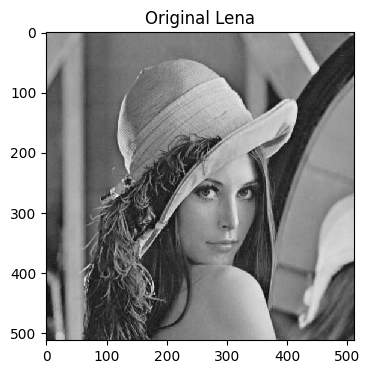

In [3]:
plt.figure(figsize=(4, 4))
plt.imshow(lena, cmap='grey', interpolation='nearest')
plt.title("Original Lena")
plt.axis('on')
plt.show()

In [4]:
print("Lena:", lena.shape, lena.dtype)

Lena: (512, 512) uint8


In [5]:
def downsample_avg(img, factor):
    h, w = img.shape
    new_h = h // factor
    new_w = w // factor

    out = np.zeros((new_h, new_w), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            block_sum = 0.0   # 🔑 float accumulator
            count = 0

            for m in range(factor):
                for n in range(factor):
                    block_sum += float(img[i * factor + m, j * factor + n])
                    count += 1

            out[i, j] = int(round(block_sum / count))

    return out


In [6]:
lena_ds = downsample_avg(lena, factor=2)
print("Downsampled shape:", lena_ds.shape)
print("Original Lena:", lena.shape)


Downsampled shape: (256, 256)
Original Lena: (512, 512)


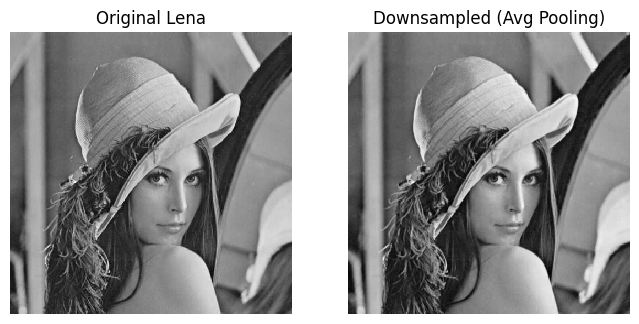

In [7]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(lena, cmap='gray', interpolation='nearest')
plt.title("Original Lena")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(lena_ds, cmap='gray', interpolation='nearest')
plt.title("Downsampled (Avg Pooling)")
plt.axis('off')

plt.show()


In [8]:
def nn_resize(img, new_h, new_w):
    h, w = img.shape
    out = np.zeros((new_h, new_w), dtype=np.uint8)

    x_ratio = h / new_h
    y_ratio = w / new_w

    for i in range(new_h):
        for j in range(new_w):
            src_x = int(i * x_ratio)
            src_y = int(j * y_ratio)

            if src_x >= h:
                src_x = h - 1
            if src_y >= w:
                src_y = w - 1

            out[i, j] = img[src_x, src_y]

    return out


In [9]:
lena_nn = nn_resize(
    lena_ds,
    lena.shape[0],
    lena.shape[1]
)


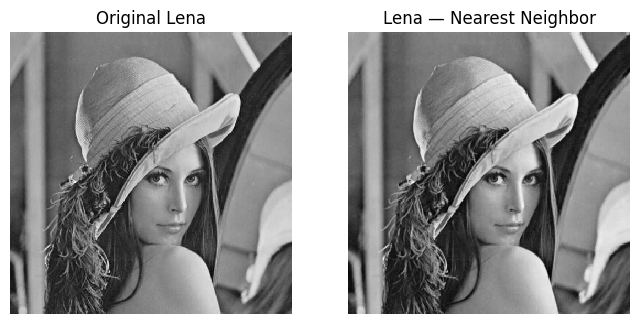

In [10]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(lena, cmap='gray', interpolation='nearest')
plt.title("Original Lena")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(lena_nn, cmap='gray', interpolation='nearest')
plt.title("Lena — Nearest Neighbor")
plt.axis('off')

plt.show()


In [11]:
def bilinear_resize(img, new_h, new_w):
    h, w = img.shape
    out = np.zeros((new_h, new_w), dtype=np.uint8)

    x_ratio = (h - 1) / new_h
    y_ratio = (w - 1) / new_w

    for i in range(new_h):
        for j in range(new_w):
            x = i * x_ratio
            y = j * y_ratio

            x0 = int(x)
            y0 = int(y)
            x1 = min(x0 + 1, h - 1)
            y1 = min(y0 + 1, w - 1)

            dx = x - x0
            dy = y - y0

            p00 = float(img[x0, y0])
            p10 = float(img[x1, y0])
            p01 = float(img[x0, y1])
            p11 = float(img[x1, y1])

            val = (
                (1 - dx) * (1 - dy) * p00 +
                dx * (1 - dy) * p10 +
                (1 - dx) * dy * p01 +
                dx * dy * p11
            )

            out[i, j] = int(round(val))

    return out


In [12]:
lena_bl = bilinear_resize(
    lena_ds,
    lena.shape[0],
    lena.shape[1]
)


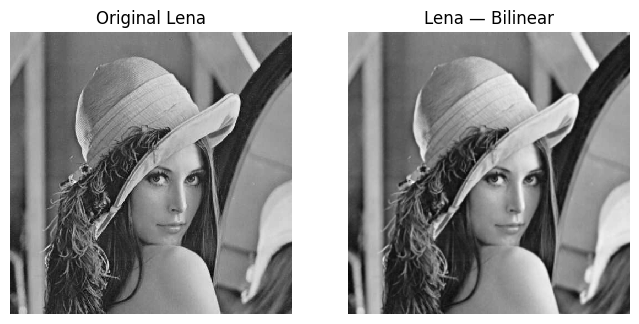

In [13]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(lena, cmap='gray', interpolation='nearest')
plt.title("Original Lena")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(lena_bl, cmap='gray', interpolation='nearest')
plt.title("Lena — Bilinear")
plt.axis('off')

plt.show()


In [14]:
def cubic(x):
    x = abs(x)
    if x <= 1:
        return 1 - 2*x*x + x*x*x
    elif x < 2:
        return 4 - 8*x + 5*x*x - x*x*x
    else:
        return 0


In [15]:
def bicubic_resize(img, new_h, new_w):
    h, w = img.shape
    out = np.zeros((new_h, new_w), dtype=np.uint8)

    x_ratio = h / new_h
    y_ratio = w / new_w

    for i in range(new_h):
        for j in range(new_w):
            x = i * x_ratio
            y = j * y_ratio

            x_int = int(x)
            y_int = int(y)

            val = 0.0
            weight_sum = 0.0

            for m in range(-1, 3):
                for n in range(-1, 3):
                    xm = x_int + m
                    yn = y_int + n

                    # 🔑 CLAMP INDICES (MUST be integers)
                    if xm < 0:
                        xm = 0
                    elif xm >= h:
                        xm = h - 1

                    if yn < 0:
                        yn = 0
                    elif yn >= w:
                        yn = w - 1

                    wx = cubic(x - (x_int + m))
                    wy = cubic(y - (y_int + n))
                    weight = wx * wy

                    val += float(img[xm, yn]) * weight
                    weight_sum += weight

            if weight_sum != 0:
                val /= weight_sum

            # clamp to valid range
            if val < 0:
                val = 0
            elif val > 255:
                val = 255

            out[i, j] = int(round(val))

    return out


In [16]:
lena_bc = bicubic_resize(
    lena_ds,
    lena.shape[0],
    lena.shape[1]
)


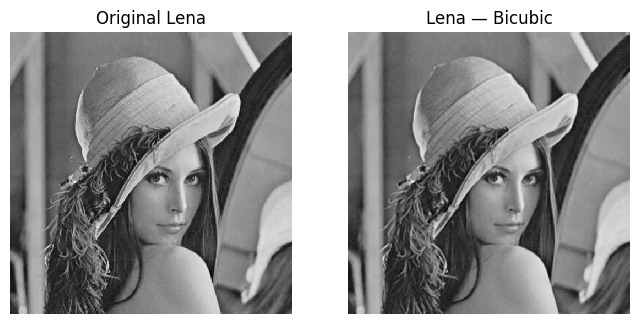

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(lena, cmap='gray', interpolation='nearest')
plt.title("Original Lena")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(lena_bc, cmap='gray', interpolation='nearest')
plt.title("Lena — Bicubic")
plt.axis('off')

plt.show()


In [18]:
def psnr(img1, img2):
    h, w = img1.shape
    mse = 0.0

    for i in range(h):
        for j in range(w):
            diff = float(img1[i, j]) - float(img2[i, j])
            mse += diff * diff

    mse /= (h * w)

    if mse == 0:
        return float('inf')

    MAX = 255.0
    return 10 * np.log10((MAX * MAX) / mse)


In [19]:
psnr_nn = psnr(lena, lena_nn)
psnr_bl = psnr(lena, lena_bl)
psnr_bc = psnr(lena, lena_bc)

print("PSNR (Nearest Neighbor):", psnr_nn)
print("PSNR (Bilinear):", psnr_bl)
print("PSNR (Bicubic):", psnr_bc)


PSNR (Nearest Neighbor): 32.199299279151596
PSNR (Bilinear): 29.407318865146642
PSNR (Bicubic): 30.989652962333093


In [20]:
print("cam min/max:", lena.min(), lena.max())
print("cam_ds min/max:", lena_ds.min(), lena_ds.max())


cam min/max: 10 255
cam_ds min/max: 23 239


In [21]:
def mae(img1, img2):
    h, w = img1.shape
    err = 0.0

    for i in range(h):
        for j in range(w):
            err += abs(float(img1[i, j]) - float(img2[i, j]))

    return err / (h * w)


In [22]:
print("MAE NN:", mae(lena, lena_nn))
print("MAE Bilinear:", mae(lena, lena_bl))
print("MAE Bicubic:", mae(lena, lena_bc))


MAE NN: 3.15618896484375
MAE Bilinear: 4.528903961181641
MAE Bicubic: 3.7759323120117188
